# **Image Captioning Bot**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Opening text data & reading captions

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

doc = load_doc('../input/text-data/Flickr8k.token.txt')
print(doc[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


Description is a dictionary in which **key** is **Image_Id** and **value** is **caption** of that Image_Id.

In [3]:
def load_description(doc):
    maps = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in maps:
            maps[image_id] = list()
        maps[image_id].append(image_desc)
    return maps

description = load_description(doc)
print(len(description))

8092


In [4]:
print(list(description.keys())[:5])

['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']


In [5]:
print(description['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


Cleaning captions by:
1. Lowering the sentance
2. Removing puntuations
3. Removing words of length less than equal to 1

In [6]:
import re

def clean_description(description):
    for key, desc_list in description.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.lower()
            desc = re.sub("[^a-z]+"," ", desc)
            desc = desc.split()
            desc = [word for word in desc if len(word) > 1]
            desc_list[i] = " ".join(desc)

clean_description(description)

In [7]:
description['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Converting the Loaded Description to Vocabulary of Words

In [8]:
def to_vocab(description):
    all_words = set()
    for key in description.keys():
        [all_words.update(sentance.split()) for sentance in description[key]]
    return all_words
vocab = to_vocab(description)
print(len(vocab))
print(list(vocab)[:5])

8424
['very', 'rolling', 'winning', 'do', 'attractive']


Saving The file description

In [9]:
def save_description(description, filename):
    lines = list()
    for key, desc_list in description.items():
        for desc in desc_list:
            lines.append(key + " " + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
save_description(description, 'descriptions.txt')

Loading Pre-defined list of photo Identifiers

In [10]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if(len(line)) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

train = load_set('../input/text-data/Flickr_8k.trainImages.txt')
print(len(train))
print(list(train)[:5])

6000
['2708582445_5e5999b956', '3134385454_4f1d55333f', '3301744710_b51280eb56', '1452361926_6d8c535e32', '1348957576_c4a78eb974']


Here, img contains **path of all the images**

In [11]:
import glob
img_path = '../input/images/Flicker8k_Dataset/'
img = glob.glob(img_path+'*.jpg')
img[:5]

['../input/images/Flicker8k_Dataset/3226254560_2f8ac147ea.jpg',
 '../input/images/Flicker8k_Dataset/214543992_ce6c0d9f9b.jpg',
 '../input/images/Flicker8k_Dataset/2366643786_9c9a830db8.jpg',
 '../input/images/Flicker8k_Dataset/3368819708_0bfa0808f8.jpg',
 '../input/images/Flicker8k_Dataset/2190227737_6e0bde2623.jpg']

In [12]:
print(len(img))

8091


Creating a **list of training Images** with their full path names

In [13]:
train_img_path = '../input/text-data/Flickr_8k.trainImages.txt'
train_img = set(open(train_img_path, 'r').read().strip().split('\n'))
train_images = []

for i in img:
    if i[len(img_path):] in train_img:
        train_images.append(i)

In [14]:
len(train_images)

6000

Creating a **list of test images** with their full path names

In [15]:
test_img_path = '../input/text-data/Flickr_8k.testImages.txt'
test_img = set(open(test_img_path, 'r').read().strip().split('\n'))
test_images = []

for i in img:
    if i[len(img_path):] in test_img:
        test_images.append(i)

In [16]:
len(test_images)

1000

Loading Clean Description

In [17]:
def load_clean_description(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq '+' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_description = load_clean_description('descriptions.txt', train)
len(train_description)

6000

In [18]:
train_description['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

1. Converting all the image to size 299 * 299
2. Converting PIL images to numpy array
3. Adding 1 more dims and preprocess the image using preprocess_input()

In [19]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from PIL import Image

def preprocess(image_path):
    images = image.load_img(image_path, target_size = (299, 299))
    x = image.img_to_array(images)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Loading Inception V3 Model

In [20]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
model = InceptionV3(weights='imagenet')

Removing Last 2 Layers from InceptionV3

In [21]:
new_model = Model(model.input, model.layers[-2].output)

Encoding all the images to vector of size (2048, )

In [22]:
def encode(image):
    image = preprocess(image)
    feature_vector = new_model.predict(image)
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])
    return feature_vector

Encode all the train Images

In [23]:
encoding_train = {}
for images in train_images:
    encoding_train[images[len(img_path):]] = encode(images)

In [24]:
print(len(encoding_train))

6000


In [25]:
import pickle
with open('encoded_train_images.pkl', 'wb') as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

Encoding all the test Images

In [26]:
encoding_test = dict()
for images in test_images:
    encoding_test[images[len(img_path):]] = encode(images)

In [27]:
with open('encoded_test_images.pkl', 'wb') as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [28]:
from pickle import dump, load
train_features = load(open('./encoded_train_images.pkl', 'rb'))
len(train_features)

6000

Creating a list of training Captions

In [29]:
all_train_captions = []
for key, desc in train_description.items():
    for caption in desc:
        all_train_captions.append(caption)
len(all_train_captions)

30000

Considering only words which are occuring atleast 10 times in a corpus

In [30]:
word_count_threshold = 10
word_counts = {}
no_of_sent = 0

for sentance in all_train_captions:
    no_of_sent += 1
    for word in sentance.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1
        
vocabulary = [word for word in word_counts if word_counts[word] >= word_count_threshold]
print("Word_Count {}".format(len(word_counts)))
print("Vocabulary_Count {}".format(len(vocabulary)))

Word_Count 7320
Vocabulary_Count 1656


In [31]:
ixtoword = {}
wordtoix = {}

idx = 1
for word in vocabulary:
    wordtoix[word] = idx
    ixtoword[idx] = word
    idx += 1

In [32]:
vocab_size = len(ixtoword) + 1
vocab_size

1657

Calculating length of description with maximum words

In [33]:
def to_lists(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(word) for word in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lists(descriptions)
    return max(len(word.split()) for word in lines)

max_lengths = max_length(train_description)
max_lengths

35

In [61]:
with open('wordtoix.pkl', 'wb') as w2i:
    pickle.dump(wordtoix, w2i)
    
with open('ixtoword.pkl', 'wb') as i2w:
    pickle.dump(ixtoword, i2w)

In [34]:
def data_generator(descriptions, photos, wordtoix, max_lengths, num_photo_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_lengths)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == num_photo_per_batch:
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

Loading Glove Vector

In [35]:
import os
glove_path = '../input/glove-global-vectors-for-word-representation'
embeddings_index = {}

file = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding='utf-8')

for line in file:
    values = line.split()
    word  = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

len(embeddings_index)

400000

In [36]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(1657, 200)

Creating the model for Image Captioning

In [37]:
inputs1 = Input(shape = (2048, ))
f1 = Dropout(0.5)(inputs1)
f2 = Dense(256, activation='relu')(f1)
inputs2 = Input(shape = (max_lengths, ))
s1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
s2 = Dropout(0.5)(s1)
s3 = LSTM(256)(s2)
decoder1 = add([f2, s3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs = [inputs1, inputs2], outputs = outputs)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 200)      331400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [39]:
model.layers[2]

Removing last 2 layers

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_description)//number_pics_per_bath

In [43]:
for i in range(epochs):
    generator = data_generator(train_description, train_features, wordtoix, max_lengths, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

2000/2000 [==============================] - 173s 86ms/step - loss: 2.7277


In [45]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_description)//number_pics_per_bath

In [47]:
for i in range(epochs):
    generator = data_generator(train_description, train_features, wordtoix, max_lengths, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

1000/1000 [==============================] - 93s 93ms/step - loss: 2.5266


In [49]:
model.load_weights('./model_9.h5')

In [50]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

Funcation to Caption the photo

In [57]:
def Caption_Photo(photo):
    in_text = 'startseq'
    for i in range(max_lengths):
        sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_lengths)
        y_pred = model.predict([photo,sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = ixtoword[y_pred]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

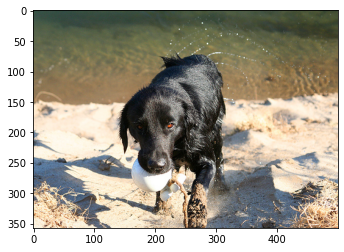

Caption :  black dog is running through the water
_____________________________________


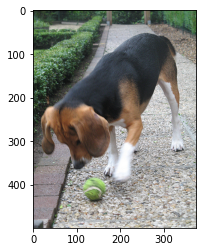

Caption :  dog is running through the woods
_____________________________________


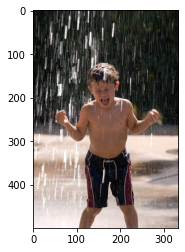

Caption :  young boy in swimsuit is jumping into pool
_____________________________________


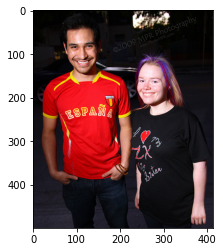

Caption :  two girls are sitting on the ground
_____________________________________


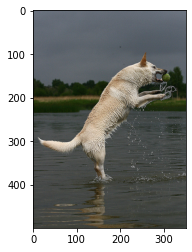

Caption :  dog is running through the water
_____________________________________


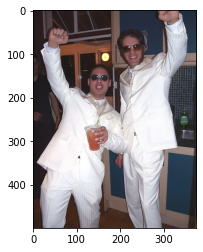

Caption :  woman in white dress is standing by the window of white building
_____________________________________


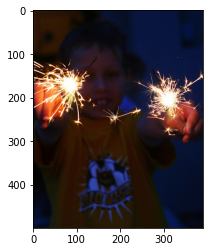

Caption :  man in white shirt is sitting on top of the water
_____________________________________


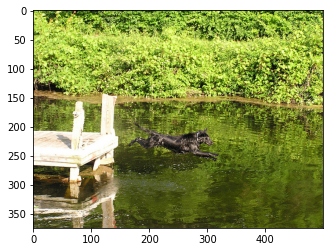

Caption :  dog is jumping into swimming pool
_____________________________________


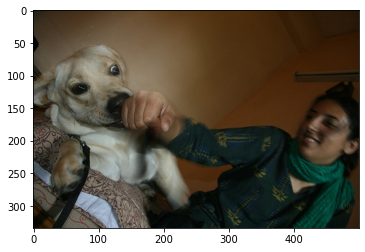

Caption :  two puppies are playing with red ball
_____________________________________


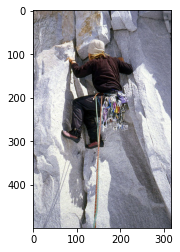

Caption :  man in red shirt is standing on the side of mountain
_____________________________________


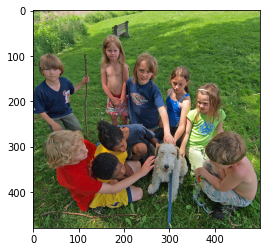

Caption :  two boys are playing with red ball
_____________________________________


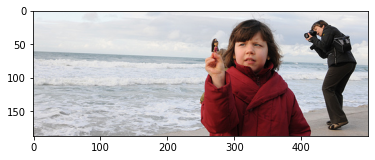

Caption :  two people are walking along the beach
_____________________________________


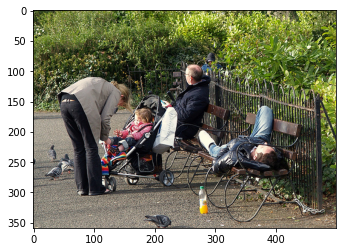

Caption :  man in blue shirt is sitting on the edge of wooden bridge
_____________________________________


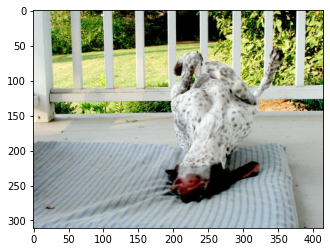

Caption :  dog is running through the grass
_____________________________________


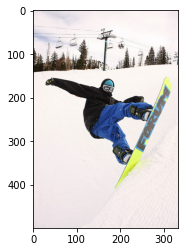

Caption :  man in red pants is snowboarding down snowy hill
_____________________________________


In [58]:
for pics in range(15):
    pic = list(encoding_test.keys())[pics]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(img_path+pic)
    plt.imshow(x)
    plt.show()
    print("Caption : ",Caption_Photo(image))
    print("_____________________________________")